In [337]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub 

from tensorflow import keras 
from keras import layers 
from keras.models import Sequential

import requests
import imutils
import urllib


In [338]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [339]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


['cats', 'dogs']


2024-04-13 21:39:48.918406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


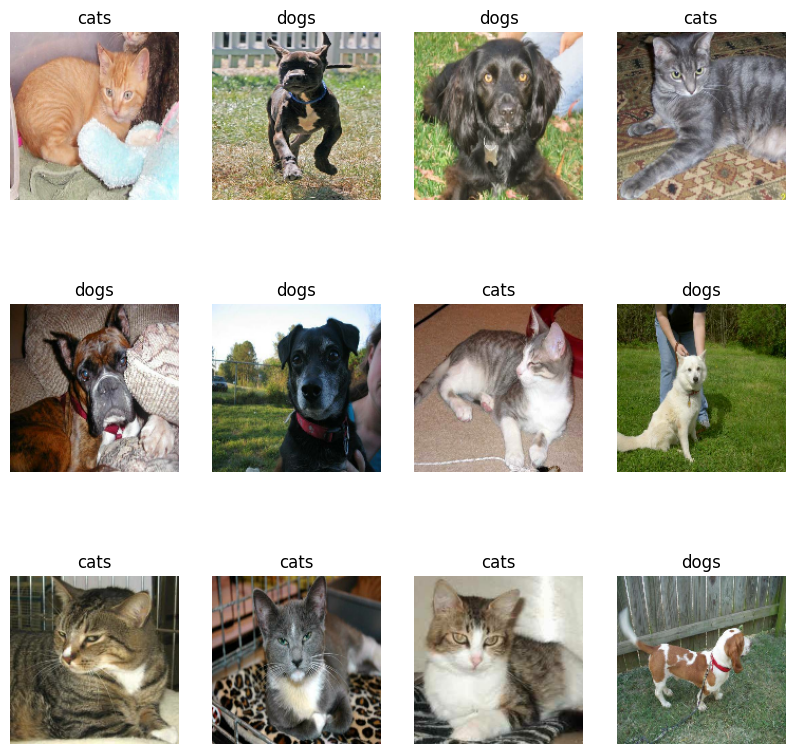

In [340]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [341]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [342]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [343]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [344]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print(AUTOTUNE)
print(tf.data.AUTOTUNE)

Number of validation batches: 26
Number of test batches: 6
-1
-1


In [345]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-04-13 21:39:49.713380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


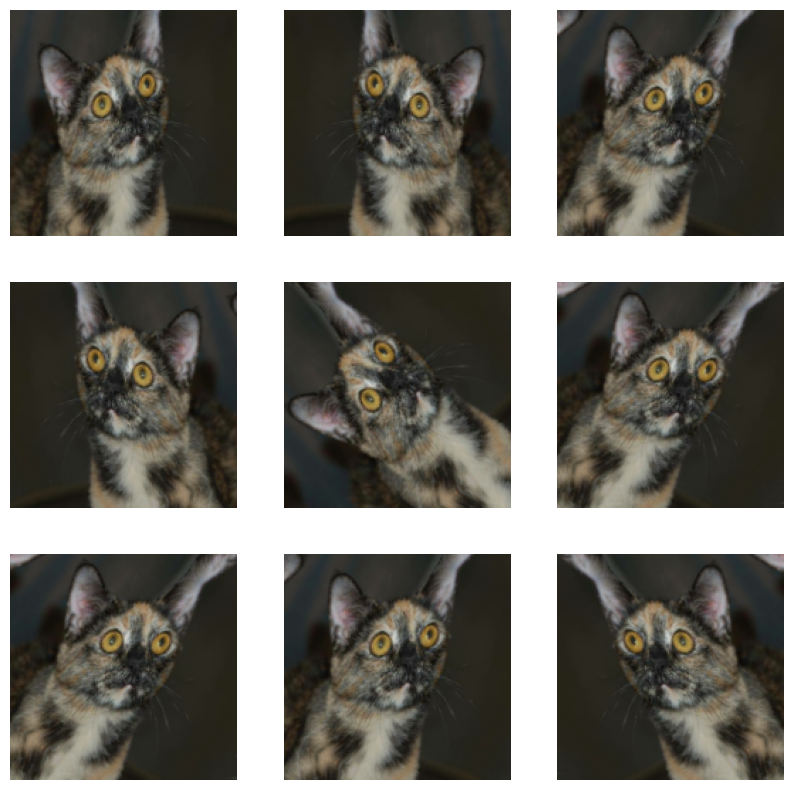

In [346]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [347]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [348]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [349]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [350]:
base_model.trainable = False

In [351]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [352]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [353]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [354]:
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_10 (TrueDivide)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_10 (Subtract)          │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [355]:
len(model.trainable_variables)

2

In [356]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [357]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [358]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.3942 - loss: 0.8945


In [359]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.92
initial accuracy: 0.37


In [360]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4691 - loss: 0.8643 - val_accuracy: 0.6795 - val_loss: 0.6036
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.6613 - loss: 0.6374 - val_accuracy: 0.8651 - val_loss: 0.4231
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.7713 - loss: 0.5003 - val_accuracy: 0.9369 - val_loss: 0.3183
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.8320 - loss: 0.4115 - val_accuracy: 0.9678 - val_loss: 0.2529
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8584 - loss: 0.3468 - val_accuracy: 0.9728 - val_loss: 0.2144
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8906 - loss: 0.3034 - val_accuracy: 0.9740 - val_loss: 0.1797
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8932 - loss: 0.2716 - val_accuracy: 0.9777 - val_loss: 0.1617
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9027 - loss: 0.2589 - val_accuracy: 0.

In [361]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9839 - loss: 0.0906
Test Loss: 0.09183818846940994
Test Accuracy: 0.9791666865348816


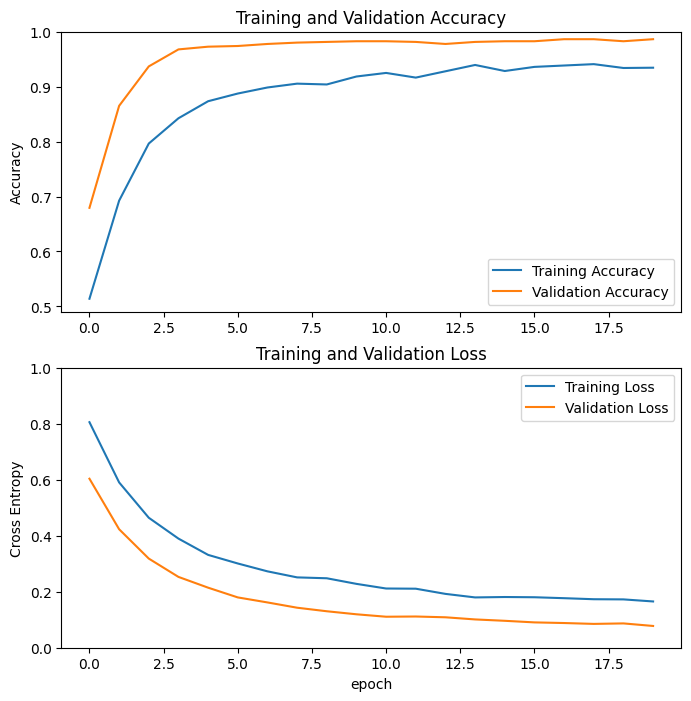

In [362]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [363]:
# url = "http://10.81.56.47:8080/video"
# capture = cv2.VideoCapture(url)

# while True:
#     _, frame = capture.read()
#     cv2.imshow("Android_cam", frame)
#     if cv2.waitKey(1) == ord("q"):
#         break
    
# capture.release()
# cv2.destroyAllWindows()

In [1]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print(len(label_batch))
plt.figure(figsize=(10, 10))
for i in range(24):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+" "+class_names[label_batch[i]])
  plt.axis("off")

NameError: name 'test_dataset' is not defined

In [2]:
url = "http://10.81.56.47:8080/video"
capture = cv2.VideoCapture(url)

while True:
    _, frame = capture.read()

    resized_frame = cv2.resize(frame, (160, 160))  # Resize to match the input size expected by the model
    resized_frame = np.expand_dims(resized_frame, axis=0)  # Add batch dimension
    resized_frame = resized_frame / 255.0  # Normalize pixel value

# Add batch dimension
    # image = np.expand_dims(resized_frame, axis=0)

# Make prediction
    predictions = model.predict(resized_frame).flatten()

    # Interpret predictions
    predicted_class = class_names[np.argmax(predictions[0])] 
    
    cv2.rectangle(frame, (10, 10), (300, 50), (0, 0, 0), -1)  # Draw filled black rectangle as background

    # Draw label on frame
    cv2.putText(frame, predicted_class, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Android_cam", frame)
    if cv2.waitKey(1) == ord("q"):
        break
    
capture.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined